In [1]:
import cohortintgrad as csig
import pandas as pd
import numpy as np
import shap, torch
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

#### Data load

In [2]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
x = data['data'][:10000]
y = data['target'][:10000]

In [3]:
pd.concat([pd.DataFrame(x, columns=data['feature_names']).describe(), pd.DataFrame(y, columns=['Target']).describe()], axis=1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,3.718040,31.847100,5.212102,1.090389,1395.588700,3.061855,35.493820,-119.472328,2.04949
std,1.916912,11.821967,2.752832,0.547035,1090.838717,6.098183,1.959545,1.808913,1.16595
min,0.499900,1.000000,0.846154,0.500000,3.000000,0.750000,32.670000,-124.350000,0.14999
25%,2.411900,23.000000,4.253385,1.007078,779.750000,2.452830,34.010000,-121.590000,1.17975
50%,3.328900,33.000000,5.031476,1.049645,1137.500000,2.851168,34.170000,-118.410000,1.76600
75%,4.544825,40.000000,5.830935,1.097466,1687.000000,3.373184,37.630000,-118.210000,2.58025
max,15.000100,52.000000,141.909091,34.066667,28566.000000,599.714286,41.950000,-114.550000,5.00001


#### Construct a Linear Model

In [4]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(
        x, y, test_size=0.2, random_state=1018
    )

In [5]:
#randomly picked data id
data_id=1018

In [6]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_x, train_y)
print(f'coefficient of the model = {lr.coef_}') 
print(f'intercept of the model = {lr.intercept_}')

coefficient of the model = [ 4.24955434e-01  6.18867650e-03 -9.62249735e-02  5.35832074e-01
  2.29219637e-05 -2.57747854e-01 -4.52738626e-01 -3.76962637e-01]
intercept of the model = -28.034035536407274


In [7]:
print(f'Preficted value for Data id={data_id}: {lr.predict(test_x[data_id].reshape(1,-1)).item()}')
print(f'Annotated value = {test_y[data_id]}')
print(np.sum(lr.coef_ * test_x[data_id]) + lr.intercept_)

Preficted value for Data id=1018: 2.16016976283116
Annotated value = 3.611
2.1601697628311634


#### Usual Kearnel SHAP

In [8]:
explainer = shap.KernelExplainer(lr.predict, data=np.average(test_x, axis=0).reshape(1, test_x.shape[1]))
sv = explainer.shap_values(test_x[data_id], max_evals=2**x.shape[1], silent=False)
print(f'Kernel Shapley value for Data id={data_id}: {sv}')
print(f'Linear coefficient times the data values comparing to the average data: {lr.coef_ * (test_x[data_id] - np.average(test_x, axis=0))}')

Kernel Shapley value for Data id=1018: [ 0.46804745 -0.02325395 -0.12718621  0.00272706 -0.01220642  0.15034828
 -1.30177295  1.06308176]
Linear coefficient times the data values comparing to the average data: [ 0.46804745 -0.02325395 -0.12718621  0.00272706 -0.01220642  0.15034828
 -1.30177295  1.06308176]


In [9]:
sv_all = explainer.shap_values(test_x, max_evals=2**x.shape[1], silent=True)

#### IGCS for annotated value

In [10]:
#build instance 
IG = csig.CohortIntGrad(test_x,test_y)
#calculate CSIG values and Remaining Delta (residue of efficiency axiom)
ig =IG.igcs_single(t_id=data_id)
print(f'IGCS for annotated y for Data id={data_id}: {ig.to("cpu").detach().numpy()}')

IGCS for annotated y for Data id=1018: [ 2.3998897e-01  2.5853822e-02 -1.3655618e-04  7.6993988e-03
 -3.1481896e-02  3.7488531e-04  2.2337019e-02  1.3618467e-02]


#### IGCS for predicted value

In [11]:
pred = lr.predict(test_x)
IG_pred = csig.CohortIntGrad(test_x,pred)
ig_pred,_ =IG_pred.igcs_stack(stack_target=list(range(test_x.shape[0]))) # IGCS for all data

100%|██████████| 2000/2000 [00:25<00:00, 78.24it/s]


In [12]:
#data shape: (#cohort, (shape of feat))~same as original data
ig_pred.shape

torch.Size([2000, 8])

In [13]:
print(f'IGCS for predicted y for Data id={data_id}: {ig_pred[data_id].to("cpu").detach().numpy()}')

IGCS for predicted y for Data id=1018: [ 0.25093773 -0.02425705  0.00229068 -0.00126117  0.0124348   0.03522481
  0.04133091  0.04580621]


#### Cohort Shapley for predicted value

In [14]:
#the case where #feat is very few and n_step is large, CS can be faster than IGCS
ks = np.vstack([IG_pred.cohort_kernel_shap(t_id=i) for i in range(test_x.shape[0])])
print(f'CS for annotated y for Data id={data_id}: {ks[data_id]}')

CS for annotated y for Data id=1018: [ 0.26491452 -0.01957971  0.00210659 -0.00432399 -0.00153431  0.02176702
  0.04633841  0.05284106]


#### observational ABC
see Section 5.1.2 in the paper

In [15]:
id_calc_igcs = csig.observational_insertion_deletion_wrapper.Loaded_Feat_Attr(
        torch.Tensor(test_x).to(device), torch.Tensor(pred).to(device), ratio=0.1, feat_attr=ig_pred.to('cpu').detach().numpy()
    )
pt_i_o_igcs,abc_i_o_igcs = id_calc_igcs.insertion_deletion_test(t_id=data_id, mode='insertion')
pt_d_o_igcs,abc_d_o_igcs = id_calc_igcs.insertion_deletion_test(t_id=data_id, mode='deletion')

In [16]:
id_calc_cs = csig.observational_insertion_deletion_wrapper.Loaded_Feat_Attr(
        torch.Tensor(test_x).to(device), torch.Tensor(pred).to(device), ratio=0.1, feat_attr=ks    )
pt_i_o_cs,abc_i_o_cs = id_calc_cs.insertion_deletion_test(t_id=data_id, mode='insertion')
pt_d_o_cs,abc_d_o_cs = id_calc_cs.insertion_deletion_test(t_id=data_id, mode='deletion')

In [17]:
id_calc_ks = csig.observational_insertion_deletion_wrapper.Loaded_Feat_Attr(
        torch.Tensor(test_x).to(device), torch.Tensor(pred).to(device), ratio=0.1, feat_attr=sv_all    )
pt_i_o_ks,abc_i_o_ks = id_calc_ks.insertion_deletion_test(t_id=data_id, mode='insertion')
pt_d_o_ks,abc_d_o_ks = id_calc_ks.insertion_deletion_test(t_id=data_id, mode='deletion')

In [18]:
print(f"Order of feats for Data id={data_id} in IGCS: {np.argsort(-ig_pred[data_id].to('cpu').detach().numpy())}, Insertion ABC: {abc_i_o_igcs}, Deletion ABC: {abc_d_o_igcs}")
print(f"Order of feats for Data id={data_id} in CS: {np.argsort(-ks[data_id])}, Insertion ABC: {abc_i_o_cs}, Deletion ABC: {abc_d_o_cs}")
print(f"Order of feats for Data id={data_id} in KS: {np.argsort(-sv_all[data_id])}, Insertion ABC: {abc_i_o_ks}, Deletion ABC: {abc_d_o_ks}")

Order of feats for Data id=1018 in IGCS: [0 7 6 5 4 2 3 1], Insertion ABC: 0.15726080536842346, Deletion ABC: 0.14387258887290955
Order of feats for Data id=1018 in CS: [0 7 6 5 2 4 3 1], Insertion ABC: 0.15908566117286682, Deletion ABC: 0.14837464690208435
Order of feats for Data id=1018 in KS: [7 0 5 3 4 1 2 6], Insertion ABC: 0.10642185807228088, Deletion ABC: 0.0925959050655365


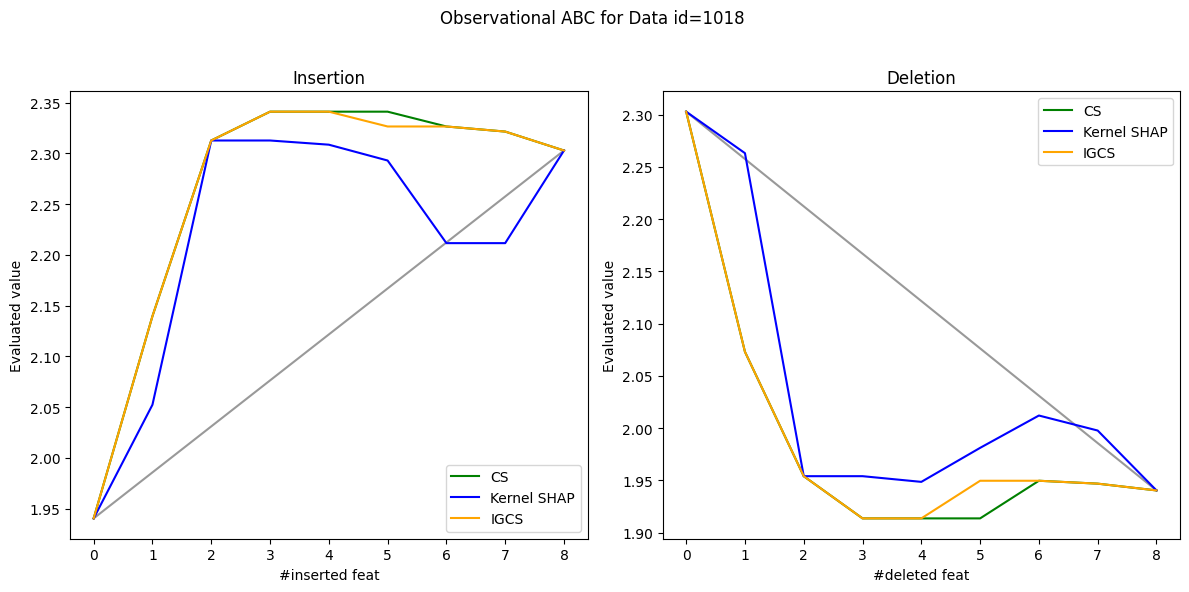

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot([0,test_x.shape[1] ], [pt_i_o_igcs[0], pt_i_o_igcs[-1]], c="0.6")
ax[0].plot(pt_i_o_cs, c='green', label='CS')
ax[0].plot(pt_i_o_ks, c='blue', label='Kernel SHAP')
ax[0].plot(pt_i_o_igcs, c='orange', label='IGCS')


ax[1].plot([0,test_x.shape[1] ], [pt_d_o_igcs[0], pt_d_o_igcs[-1]], c="0.6")   
ax[1].plot(pt_d_o_cs, c='green', label='CS')
ax[1].plot(pt_d_o_ks, c='blue', label='Kernel SHAP')
ax[1].plot(pt_d_o_igcs, c='orange', label='IGCS')


ax[0].set_xlabel(f'#inserted feat')
ax[0].set_title('Insertion')
ax[1].set_xlabel(f'#deleted feat')
ax[1].set_title('Deletion')
for i in range(2): 
    ax[i].legend()
    ax[i].set_ylabel(f'Evaluated value')
fig.suptitle(f"Observational ABC for Data id={data_id} " )
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [20]:
plt.close();plt.clf()

<Figure size 640x480 with 0 Axes>

#### interventional ABC 

In [21]:
id_calc_igcs_iv = csig.insertion_deletion.Insertion_Deletion_ABC_calc(target=test_x[data_id],
        reference=np.average(test_x, axis=0),
        feat_attr=ig_pred[data_id].to('cpu').detach().numpy(),
        pred_function=lr.predict,
        mode="insertion",
        torch_cast=False,)
pt_i_iv_igcs,abc_i_iv_igcs = id_calc_igcs_iv.calc_abc()
id_calc_igcs_iv_d = csig.insertion_deletion.Insertion_Deletion_ABC_calc(target=test_x[data_id],
        reference=np.average(test_x, axis=0),
        feat_attr=ig_pred[data_id].to('cpu').detach().numpy(),
        pred_function=lr.predict,
        mode="deletion",
        torch_cast=False,)
pt_d_iv_igcs,abc_d_iv_igcs = id_calc_igcs_iv_d.calc_abc()

In [22]:
id_calc_cs_iv = csig.insertion_deletion.Insertion_Deletion_ABC_calc(target=test_x[data_id],
        reference=np.average(test_x, axis=0),
        feat_attr=ks[data_id],
        pred_function=lr.predict,
        mode="insertion",
        torch_cast=False,)
pt_i_iv_cs,abc_i_iv_cs = id_calc_cs_iv.calc_abc()
id_calc_cs_iv_d = csig.insertion_deletion.Insertion_Deletion_ABC_calc(target=test_x[data_id],
        reference=np.average(test_x, axis=0),
        feat_attr=ks[data_id],
        pred_function=lr.predict,
        mode="deletion",
        torch_cast=False,)
pt_d_iv_cs,abc_d_iv_cs = id_calc_cs_iv_d.calc_abc()

In [23]:
id_calc_ks_iv = csig.insertion_deletion.Insertion_Deletion_ABC_calc(target=test_x[data_id],
        reference=np.average(test_x, axis=0),
        feat_attr=sv_all[data_id],
        pred_function=lr.predict,
        mode="insertion",
        torch_cast=False,)
pt_i_iv_ks,abc_i_iv_ks = id_calc_ks_iv.calc_abc()
id_calc_ks_iv_d = csig.insertion_deletion.Insertion_Deletion_ABC_calc(target=test_x[data_id],
        reference=np.average(test_x, axis=0),
        feat_attr=sv_all[data_id],
        pred_function=lr.predict,
        mode="deletion",
        torch_cast=False,)
pt_d_iv_ks,abc_d_iv_ks = id_calc_ks_iv_d.calc_abc()

In [24]:
print(f"IGCS Insertion ABC: {abc_i_o_igcs}, Deletion ABC: {abc_d_o_igcs}")
print(f"CS Insertion ABC: {abc_i_o_cs}, Deletion ABC: {abc_d_o_cs}")
print(f"KS Insertion ABC: {abc_i_o_ks}, Deletion ABC: {abc_d_o_ks}")

IGCS Insertion ABC: 0.15726080536842346, Deletion ABC: 0.14387258887290955
CS Insertion ABC: 0.15908566117286682, Deletion ABC: 0.14837464690208435
KS Insertion ABC: 0.10642185807228088, Deletion ABC: 0.0925959050655365


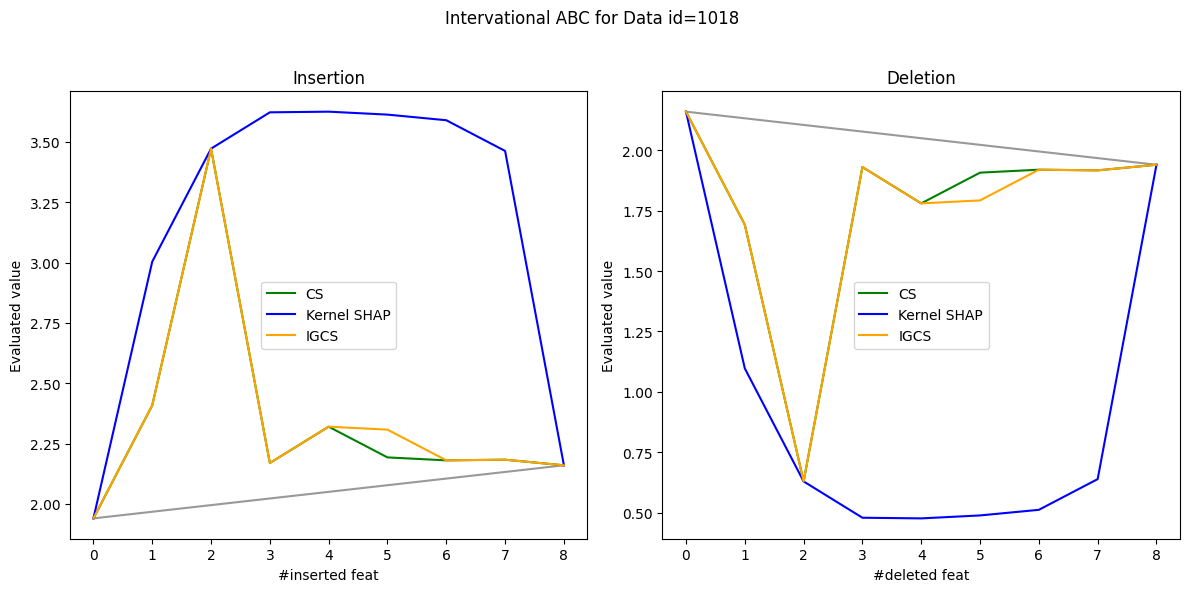

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot([0,test_x.shape[1] ], [pt_i_iv_igcs[0], pt_i_iv_igcs[-1]], c="0.6")
ax[0].plot(pt_i_iv_cs, c='green', label='CS')
ax[0].plot(pt_i_iv_ks, c='blue', label='Kernel SHAP')
ax[0].plot(pt_i_iv_igcs, c='orange', label='IGCS')


ax[1].plot([0,test_x.shape[1] ], [pt_d_iv_igcs[0], pt_d_iv_igcs[-1]], c="0.6")   
ax[1].plot(pt_d_iv_cs, c='green', label='CS')
ax[1].plot(pt_d_iv_ks, c='blue', label='Kernel SHAP')
ax[1].plot(pt_d_iv_igcs, c='orange', label='IGCS')


ax[0].set_xlabel(f'#inserted feat')
ax[0].set_title('Insertion')
ax[1].set_xlabel(f'#deleted feat')
ax[1].set_title('Deletion')
for i in range(2): 
    ax[i].legend()
    ax[i].set_ylabel(f'Evaluated value')
fig.suptitle(f"Intervational ABC for Data id={data_id} " )
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [26]:
plt.close();plt.clf()

<Figure size 640x480 with 0 Axes>

As expected, observational type XAI (CS and CSIG) perform better observational ABC, and interventional type Kernel SHAP gained large ABC evaluated in interventional way.